## 국민연금 데이터 분석

In [10]:
# [분석 목표]
# 월별 탈퇴 기업
# 시도별 탈퇴한 기업
# 상하반기 탈퇴한 기업

#  회사명을 입력을 하면,
#  회사명을 기준으로 간단한 정보출력
#  회사에 근무하신 직원들의 평균적인 월급여 추정액, 연봉추정액, 가입자 수 출력

#  동종 업종 대비 평균 연봉의 차이
#  동종 업계는 얼마 정도 받는지 출력.

In [11]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# colab 한글 fonts-nanum 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [13]:
plt.rc('font', family='NanumBarunGothic')
# ★세션 다시 시작

In [14]:
# pandas 표시 옵션 설정
pd.set_option('display.float_format',  '{:.1f}'.format) # # 6.170000e+06 -> 6170000.0 로 표시
pd.set_option('display.max_columns', None)
  # DataFrame을 출력할 때 보여줄 수 있는 최대 컬럼 수를 설정
  #  None을 주면 모든 컬럼을 숨김 없이 출력


# 데이터셋 소개

- 데이터셋: **국민연금공단_국민연금 가입 사업장 내역**
  - 출처: 공공 데이터 포털(data.go.kr)
  - https://www.data.go.kr/data/15083277/fileData.do

- 형태: 파일데이터 (csv)


- 사업장 컬럼별 상세설명

  - 자료생성년월 → 자격마감일(사유발생일이 속하는 달의 다음달 15일)까지 신고분 반영
  - 가입자 수 → 가입자 수(고지인원 수 포함)
  - 당월고지금액 → 국민연금법 시행령 제5조에 의거 기준소득월액 상한액 적용으로 실제소득과 고지금액은 상이할 수 있음

    - ■ 상한액 2019.7.~2020.6. 4,860,000원(2019.7.1.기준)
    - ■ 상한액 2020.7.~2021.6. 5,030,000원(2020.7.1.기준)
    - ■ 상한액 2021.7.~2022.6. 5,240,000원(2021.7.1.기준)

  - 신규취득자수 → 납부재개 포함 : ※ 전달 고지대상자와 비교하므로 실제 취득자와 상이할 수 있음 (초일취득 (고지)초일이 아닌경우 (당월 미고지되며 다음달 취득자수에 반영)
  - 상실가입자수 → 납부예외 포함 : ※ 전달 고지대상자와 비교하므로 실제 퇴사자와 상이할 수 있음 (초일이 아닌 상실자는 다음달 상실자수에 반영)

※ 국민연금법 제6조, 8조, 동법 시행령 제18조에 의거 60세 도달하거나 퇴직연금수급자, 조기노령연금 수급권을 취득한 자는 가입대상에서 제외되며, 18세미만, 기초수급자는 본인희망에 의해 제외될 수 있음

# 데이터 로딩

In [15]:
"""
CSV 다운로드 해서 저장해주세요
"""
None

In [16]:
DATA_DIR = '.'

In [17]:
FILE_NAME = r'국민연금공단_국민연금 가입 사업장 내역_20250724.csv'
df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME), encoding='cp949')
df.head(3)

/tmp/ipython-input-4193290769.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME), encoding='cp949')


,자료생성년월,사업장명,사업자등록번호,사업장가입상태코드 1 등록 2 탈퇴,우편번호,사업장지번상세주소,사업장도로명상세주소,고객법정동주소코드,고객행정동주소코드,법정동주소광역시도코드,법정동주소광역시시군구코드,법정동주소광역시시군구읍면동코드,사업장형태구분코드 1 법인 2 개인,사업장업종코드,사업장업종코드명,적용일자,재등록일자,탈퇴일자,가입자수,당월고지금액,신규취득자수,상실가입자수
0,2025-06,우성기전(주),126811,1,12816,경기도 광주시 도척면,경기도 광주시 도척면 도척윗로,4161033025,4161033025,41,610,330,1,292201,동력식 수지 공구 제조업,1988-01-01,NaN,NaN,4,809160,0,0
1,2025-06,희성전자(주),106810,1,04410,서울특별시 용산구 한남동,서울특별시 용산구 독서당로14길,1117013100,1117067000,11,170,131,1,701201,비주거용 건물 임대업(점포 자기땅),1988-01-01,NaN,NaN,315,166182500,1,2
2,2025-06,디에스디엘(주),104811,1,04526,서울특별시 중구 남대문로4가,서울특별시 중구 세종대로,1114011700,1114054000,11,140,117,1,701201,비주거용 건물 임대업(점포 자기땅),1988-01-01,NaN,NaN,16,5276400,0,0


In [18]:
# shape 확인
df.shape

(594513, 22)

In [19]:
# info 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594513 entries, 0 to 594512
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   자료생성년월               594513 non-null  object
 1   사업장명                 594513 non-null  object
 2   사업자등록번호              594513 non-null  int64 
 3   사업장가입상태코드 1 등록 2 탈퇴  594513 non-null  int64 
 4   우편번호                 594513 non-null  object
 5   사업장지번상세주소            594513 non-null  object
 6   사업장도로명상세주소           573373 non-null  object
 7   고객법정동주소코드            594513 non-null  int64 
 8   고객행정동주소코드            594513 non-null  object
 9   법정동주소광역시도코드          594513 non-null  int64 
 10  법정동주소광역시시군구코드        594513 non-null  int64 
 11  법정동주소광역시시군구읍면동코드     594513 non-null  int64 
 12  사업장형태구분코드 1 법인 2 개인  594513 non-null  int64 
 13  사업장업종코드              594513 non-null  int64 
 14  사업장업종코드명             593781 non-null  object
 15  적용일자                 594512 non-nu

# 전처리

## 컬럼명 변경하기
원본 DataFrame을 다음의 컬럼명으로 변경하세요
- **삭제**로 표기된 컬럼은 삭제 합니다.



|                          변경 전 | 변경 후                 |
| -------------------------------: | ----------------------- |
|                     자료생성년월 | **삭제**                |
|                         사업장명 | 사업장명                |
|                   사업자등록번호 | 사업자등록번호          |
| 사업장가입상태코드 1 등록 2 탈퇴 | 가입상태                |
|                         우편번호 | **우편번호**            |
|               사업장지번상세주소 | **삭제**                |
|             사업장도로명상세주소 | 주소                    |
|               고객법정동주소코드 | **삭제**                |
|               고객행정동주소코드 | **삭제**                |
|           법정동주소광역시도코드 | 시도코드                |
|       법정동주소광역시시군구코드 | 시군구코드              |
| 법정동주소광역시시군구읍면동코드 | 읍면동코드              |
| 사업장형태구분코드 1 법인 2 개인 | **삭제**                |
|                   사업장업종코드 | 업종코드                |
|                 사업장업종코드명 | 업종코드명              |
|                         적용일자 | **삭제**                |
|                       재등록일자 | **삭제**                |
|                         탈퇴일자 | 탈퇴일자                |
|                         가입자수 | 가입자수                |
|                     당월고지금액 | 금액                    |
|                     신규취득자수 | 신규                    |
|                     상실가입자수 | 상실                    |



In [20]:
# 원본 컬럼명 확인
df.columns

Index(['자료생성년월', '사업장명', '사업자등록번호', '사업장가입상태코드 1 등록 2 탈퇴', '우편번호', '사업장지번상세주소',
       '사업장도로명상세주소', '고객법정동주소코드', '고객행정동주소코드', '법정동주소광역시도코드', '법정동주소광역시시군구코드',
       '법정동주소광역시시군구읍면동코드', '사업장형태구분코드 1 법인 2 개인', '사업장업종코드', '사업장업종코드명',
       '적용일자', '재등록일자', '탈퇴일자', '가입자수', '당월고지금액', '신규취득자수', '상실가입자수'],
      dtype='object')

In [21]:
# 컬럼명 변경하기
df.columns = [
    '자료생성년월', '사업장명', '사업자등록번호', '가입상태', '우편번호',
    '사업장지번상세주소', '주소', '고객법정동주소코드', '고객행정동주소코드',
    '시도코드', '시군구코드', '읍면동코드',
    '사업장형태구분코드 1 법인 2 개인', '업종코드', '업종코드명',
    '적용일자', '재등록일자', '탈퇴일자',
    '가입자수', '금액', '신규', '상실'
]

# 8개 컬럼 삭제하기
df.drop([
    '자료생성년월', '우편번호', '사업장지번상세주소', '고객법정동주소코드',
    '고객행정동주소코드', '사업장형태구분코드 1 법인 2 개인', '적용일자', '재등록일자'
], inplace=True, axis=1)

# shape 확인하기
print(df.shape)  # (..., 14)

df.head()

(594513, 14)


,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
0,우성기전(주),126811,1,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,NaN,4,809160,0,0
1,희성전자(주),106810,1,서울특별시 용산구 독서당로14길,11,170,131,701201,비주거용 건물 임대업(점포 자기땅),NaN,315,166182500,1,2
2,디에스디엘(주),104811,1,서울특별시 중구 세종대로,11,140,117,701201,비주거용 건물 임대업(점포 자기땅),NaN,16,5276400,0,0
3,(주)헤럴드,104810,1,서울특별시 용산구 후암로4길,11,170,101,221200,잡지 및 정기 간행물 발행업,NaN,321,133215600,8,3
4,천일해운(주),105816,1,서울특별시 용산구 대사관로12길,11,170,131,519113,상품 종합 도매업,NaN,9,2664040,0,0


## NaN 처리하기

In [22]:
df.columns  # 컬럼명 확인

Index(['사업장명', '사업자등록번호', '가입상태', '주소', '시도코드', '시군구코드', '읍면동코드', '업종코드',
       '업종코드명', '탈퇴일자', '가입자수', '금액', '신규', '상실'],
      dtype='object')

In [23]:
# 특정 컬럼에 대해서만 dropna 하기
df.dropna(subset=['사업장명', '사업자등록번호'], inplace=True)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594513 entries, 0 to 594512
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   사업장명     594513 non-null  object
 1   사업자등록번호  594513 non-null  int64 
 2   가입상태     594513 non-null  int64 
 3   주소       573373 non-null  object
 4   시도코드     594513 non-null  int64 
 5   시군구코드    594513 non-null  int64 
 6   읍면동코드    594513 non-null  int64 
 7   업종코드     594513 non-null  int64 
 8   업종코드명    593781 non-null  object
 9   탈퇴일자     39689 non-null   object
 10  가입자수     594513 non-null  int64 
 11  금액       594513 non-null  int64 
 12  신규       594513 non-null  int64 
 13  상실       594513 non-null  int64 
dtypes: int64(10), object(4)
memory usage: 63.5+ MB


In [25]:
df.shape # shape 확인

(594513, 14)

## 사업장명 클린징

- 다음의 예제을 확인한 후 아래 지시사항을 수행해 주세요

In [26]:
# 사업장명에서 (주) 를 제거해보자.

df.loc[df['사업장명'].str.contains(r'\(주\)')]


,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
0,우성기전(주),126811,1,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,NaN,4,809160,0,0
1,희성전자(주),106810,1,서울특별시 용산구 독서당로14길,11,170,131,701201,비주거용 건물 임대업(점포 자기땅),NaN,315,166182500,1,2
2,디에스디엘(주),104811,1,서울특별시 중구 세종대로,11,140,117,701201,비주거용 건물 임대업(점포 자기땅),NaN,16,5276400,0,0
3,(주)헤럴드,104810,1,서울특별시 용산구 후암로4길,11,170,101,221200,잡지 및 정기 간행물 발행업,NaN,321,133215600,8,3
4,천일해운(주),105816,1,서울특별시 용산구 대사관로12길,11,170,131,519113,상품 종합 도매업,NaN,9,2664040,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594501,엔알종합건설(주)-(일용)가축분뉴 공동자원화(에너지화)시설사업 설치공사중 토목공사,301812,1,NaN,48,820,430,451204,지반조성 건설업,NaN,8,2302160,8,0
594504,서광전기통신공사(주)/일용/서오창테크노밸리 중 전기공사(가로등 및 신호등),315813,1,NaN,43,114,253,452127,일반 통신 공사업,NaN,3,1341900,3,1
594505,(주) 더 피플/상용/2025년 공원녹지 유지관리사업(8구간),348860,1,NaN,51,130,380,451400,조경 건설업,NaN,3,463760,3,0
594506,대성개발(주)/일용/성남신촌 공공주택지구 조성공사 중 지구외상수도공사,141811,1,경기도 성남시 수정구 대왕판교로,41,131,112,452131,기타 옥외 시설물 축조관련 전문공사업,NaN,8,1509820,8,0


`우성기전(주)`에서 (주) 라는 글자는 제거하는 경우

In [27]:
# Regular Expression(정규화) 모듈 사용
import re

pattern1 = r'(\([^)]+\))'
re.sub(pattern1, '', '우성기전(주)')


'우성기전'

사업장명에서 [] 특수문자를 포함하는 경우 []안쪽 글자까지 제거하는 경우

In [28]:
# 사업장명 에 [] 가 있는 것들 확인
df.loc[df['사업장명'].str.contains(r'\[')]


,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
110258,에스티테크[주],606817,1,부산광역시 사하구 감천항로419번길,26,380,107,291502,기타 물품 취급장비 제조업,NaN,11,4336240,0,0
157141,게스트하우스 [특별자활],206826,1,서울특별시 성동구 가람길,11,200,118,999999,BIZ_NO미존재사업장,NaN,12,1743120,1,0
157729,[주)한빛관리 은행대우 3차1단지/ 생활지원센타],212813,1,경기도 시흥시 은행로,41,390,106,702003,비주거용 부동산 관리업,NaN,4,1108520,0,0
163548,비전트레이닝센터[자활사업],206826,1,서울특별시 성동구 자동차시장길,11,200,122,999999,BIZ_NO미존재사업장,NaN,18,1368680,2,4
181070,바이오코리아[BIOKOREA],317826,1,충청북도 청주시 흥덕구 오송읍 오송생명2로,43,113,250,999999,BIZ_NO미존재사업장,NaN,3,671020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594072,주식회사에코에너젠/상용/[청주4캠퍼스]25년 M15 Mid Scr. E.P Stage세정,125818,1,충청북도 청주시 흥덕구 대신로,43,113,136,291902,산업용 냉장 및 냉동장비 제조업,NaN,7,2115880,7,0
594095,금양그린파워（주）/일용/[청주3캠퍼스] 25년 2분기 M11 이설장비 H-up 전기공사,610811,1,충청북도 청주시 흥덕구 대신로,43,113,136,451200,기타 토목 시설물 건설업,NaN,49,17649840,5,1
594184,(주)대양이엔아이-(상용)[이천캠퍼스] P&T4 VOC System 농축기 Zeol...,133812,1,경기도 이천시 부발읍 경충대로,41,500,350,291905,기체 여과기 제조업,NaN,4,1516380,4,0
594348,(주)금화피에스시/일용/[당진 9호기] 미분기 #C 4만 시간 예방정비공사,120810,1,충청남도 당진시 석문면 교로길,44,270,320,452126,내부 전기배선 공사업,NaN,4,1330200,4,0


(예시) `에스티테크[주]`에서 [주]를 삭제 하고 싶은 경우

In [29]:
pattern2 = r'(\[[^)]+\])'
re.sub(pattern2, '', '에스티테크[ 주 ]')


'에스티테크'

In [30]:
# 사업장명에 특수문자  가령. '/' 이 있는 경우
df.loc[df['사업장명'].str.contains(r'\/')]


,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
926,(주)동양/건재부문,101853,1,서울특별시 영등포구 국제금융로2길,11,560,110,269401,시멘트 제조업,NaN,302,145026780,9,1
2116,재우교통/주,205812,1,서울특별시 마포구 가양대로,11,440,127,602201,택시 운송업,NaN,3,823400,0,0
4790,(주)한영파트너스FH/월드컵현대아파트,138810,1,서울특별시 서대문구 수색로,11,410,119,702003,비주거용 부동산 관리업,NaN,3,983400,0,0
17392,의료법인해정의료재단/더좋은병원,502821,1,대구광역시 수성구 명덕로,27,260,105,851101,요양병원,NaN,199,49408920,4,2
20820,사)강원도지체장애인협회고성군지회/장애인종합상담실/편의,227826,1,강원특별자치도 고성군 간성읍 간성로30번길,51,820,250,999999,BIZ_NO미존재사업장,NaN,3,918520,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594504,서광전기통신공사(주)/일용/서오창테크노밸리 중 전기공사(가로등 및 신호등),315813,1,NaN,43,114,253,452127,일반 통신 공사업,NaN,3,1341900,3,1
594505,(주) 더 피플/상용/2025년 공원녹지 유지관리사업(8구간),348860,1,NaN,51,130,380,451400,조경 건설업,NaN,3,463760,3,0
594506,대성개발(주)/일용/성남신촌 공공주택지구 조성공사 중 지구외상수도공사,141811,1,경기도 성남시 수정구 대왕판교로,41,131,112,452131,기타 옥외 시설물 축조관련 전문공사업,NaN,8,1509820,8,0
594509,한림정공주식회사/일용/경동나비엔 서탄공장 열교환기동 증축공사중 사이포닉 우배수공사(...,116812,1,경기도 평택시 서탄면 수월암길,41,220,320,452103,보링 그라우팅 및 관정 공사업,NaN,4,1648800,4,0


그 밖의 모든 특수문자는 제거합니다. (제거한 특수문자에는 공백을 삽입합니다)

In [31]:
pattern3 = '[^A-Za-z0-9가-힣]'  # 앞의 ^ 는 exclusively
result = re.sub(pattern3, ' ', '*^%$^의료법인%해정^&*****%!@의료재단/더/좋은/병원')
result = re.sub(' +', ' ', result)
result


' 의료법인 해정 의료재단 더 좋은 병원'

In [32]:
# 검증코드 (변경전)
# ※ 위 확인 내용에서 index 값 가져옵니다.
df.loc[[0, 110258, 926]]


,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
0,우성기전(주),126811,1,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,NaN,4,809160,0,0
110258,에스티테크[주],606817,1,부산광역시 사하구 감천항로419번길,26,380,107,291502,기타 물품 취급장비 제조업,NaN,11,4336240,0,0
926,(주)동양/건재부문,101853,1,서울특별시 영등포구 국제금융로2길,11,560,110,269401,시멘트 제조업,NaN,302,145026780,9,1


위의 제공된 힌트를 참고하여 `사업장명` 컬럼에 대하여 다음 조건의 클린징을 적용해 주세요

1. `(주)` 와 같은 문자열은 ()안에 문자를 포함하여 일괄 제거합니다.
2. `[주식회사]`와 같이 [] 안에 문자열 포함하여 일괄 제거합니다.
3. `숫자`, `한글`, `영어`를 제외한 특수문자는 공백으로 대체 합니다. 만약 공백이 1개 이상이 들어간 경우는 1개로 대체합니다.

In [33]:
# 코드를 입력해 주세요
def preprocessing(x):
    x = re.sub(pattern1, '', x)   # () 제거
    x = re.sub(pattern2, '', x)   # [] 제거
    x = re.sub(pattern3, ' ', x)  # 그 밖의 특수문자 제거
    x = re.sub(' +', ' ', x)    # 공백 여러개도 한개로 축소
    return x.strip()

  # () 제거
  # [] 제거
  # 그 밖의 특수문자 제거
  # 공백 여러개도 한개로 축소


# apply 하기
df['사업장명'] = df['사업장명'].apply(preprocessing)

In [34]:
# 검증코드 (변경후)
df.loc[[0, 110258, 926]]


,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
0,우성기전,126811,1,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,NaN,4,809160,0,0
110258,에스티테크,606817,1,부산광역시 사하구 감천항로419번길,26,380,107,291502,기타 물품 취급장비 제조업,NaN,11,4336240,0,0
926,동양 건재부문,101853,1,서울특별시 영등포구 국제금융로2길,11,560,110,269401,시멘트 제조업,NaN,302,145026780,9,1


# 분석

## 월별 탈퇴 기업수
특정연도에 탈퇴한 기업의 월별 탈퇴 수를 bar그래프로 출력합니다.

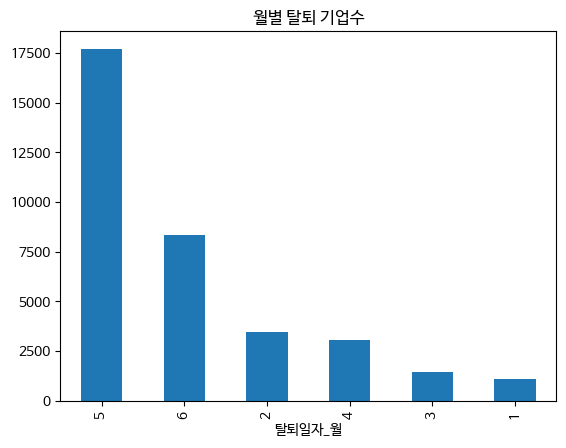

In [35]:
year = 2025

df['탈퇴일자_연도'] = pd.to_datetime(df['탈퇴일자']).dt.year
df['탈퇴일자_월'] = pd.to_datetime(df['탈퇴일자']).dt.month

df.loc[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == year), '탈퇴일자_월'].astype(int).value_counts().plot(kind='bar')

plt.title('월별 탈퇴 기업수')
plt.show()

## 시도별 탈퇴한 기업수
특정연도에 탈퇴한 기업을 대상으로 시도별 탈퇴한 기업의 숫자를 bar 그래프로 출력하세요

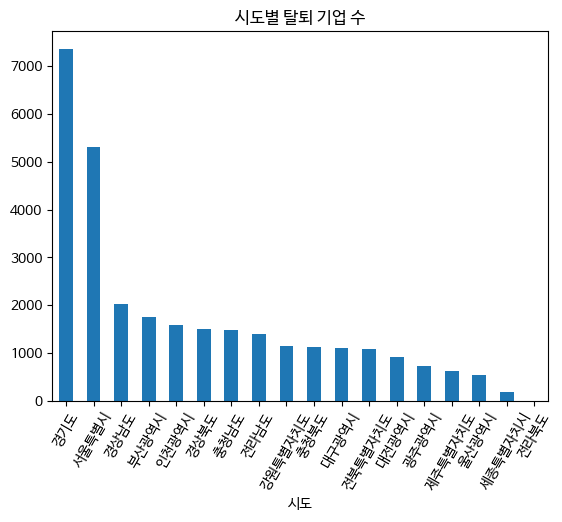

In [36]:
df['시도'] = df['주소'].str.split().str[0]

df.loc[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == year) & (df['시도'].apply(lambda x: len(str(x).strip())) > 0), '시도'].value_counts().plot(kind='bar')

plt.title('시도별 탈퇴 기업 수')
plt.xticks(rotation=60)
plt.show()

## 상하반기 기업탈퇴수 비교
탈퇴한 기업을 대상으로 상반기 / 하반기별 기업의 탈퇴 수를 비교합니다.
- 비교대상은 start_year년 ~ end_year년을 기준으로 산정합니다.

In [37]:
# ※데이터 공식 페이지의 당월 고지 금액 참조
start_year = 2021
end_year = 2025


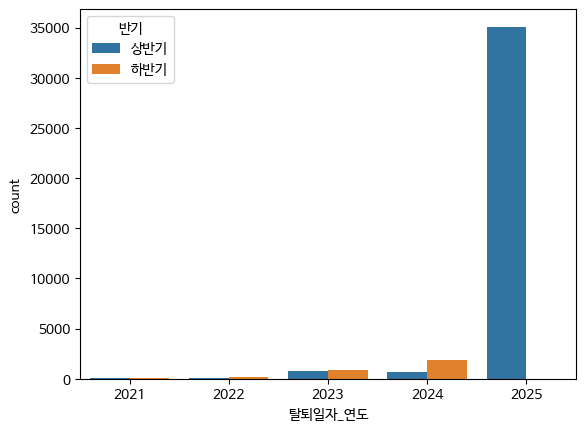

In [38]:
cond1 = (df['가입상태'] == 2) & (df['탈퇴일자_연도'] >= start_year) & (df['탈퇴일자_연도'] <= end_year)
tmp = df.loc[cond1].copy()
tmp['반기'] = np.where(tmp['탈퇴일자_월'] <= 6, '상반기', '하반기')
tmp['탈퇴일자_연도'] = tmp['탈퇴일자_연도'].astype('int')
sns.countplot(data=tmp, x='탈퇴일자_연도', hue='반기')
plt.show()


In [39]:
df.drop(['탈퇴일자_연도', '탈퇴일자_월', '시도'], axis=1, inplace=True)

df

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
0,우성기전,126811,1,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,NaN,4,809160,0,0
1,희성전자,106810,1,서울특별시 용산구 독서당로14길,11,170,131,701201,비주거용 건물 임대업(점포 자기땅),NaN,315,166182500,1,2
2,디에스디엘,104811,1,서울특별시 중구 세종대로,11,140,117,701201,비주거용 건물 임대업(점포 자기땅),NaN,16,5276400,0,0
3,헤럴드,104810,1,서울특별시 용산구 후암로4길,11,170,101,221200,잡지 및 정기 간행물 발행업,NaN,321,133215600,8,3
4,천일해운,105816,1,서울특별시 용산구 대사관로12길,11,170,131,519113,상품 종합 도매업,NaN,9,2664040,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594508,빛과공간건설주식회사 고성읍 커뮤니티 큐어센터 건립공사 중 실내건축공사,773860,1,NaN,48,820,250,452106,도배 실내 장식 및 내장 목공사업,NaN,3,1011600,3,3
594509,한림정공주식회사 일용 경동나비엔 서탄공장 열교환기동 증축공사중 사이포닉 우배수공사,116812,1,경기도 평택시 서탄면 수월암길,41,220,320,452103,보링 그라우팅 및 관정 공사업,NaN,4,1648800,4,0
594510,동림산업 일용 바이오중요 연료저장탱크 Return Line 배관교체 공사,417811,1,제주특별자치도 서귀포시 안덕면 화순해안로106번길,50,130,310,452125,일반 전기 공사업,NaN,3,1034080,3,0
594511,주 동인건설 대운동장 시설개선공사,301815,1,충청북도 영동군 영동읍 계산로,43,740,250,452102,유리 및 창호 공사업,NaN,3,979180,3,0


## 탈퇴 기업 삭제
- `가입상태`가 2 (탈퇴)인 데이터는 삭제 합니다.
- `가입상태`, `탈퇴일자` 컬럼을 제거하세요.

In [40]:
df = df.loc[df['가입상태'] == 1].drop(['가입상태', '탈퇴일자'], axis=1).reset_index(drop=True)

print(f'shape: {df.shape[0]} 행')
df.head()

shape: 554822 행


,사업장명,사업자등록번호,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,가입자수,금액,신규,상실
0,우성기전,126811,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,4,809160,0,0
1,희성전자,106810,서울특별시 용산구 독서당로14길,11,170,131,701201,비주거용 건물 임대업(점포 자기땅),315,166182500,1,2
2,디에스디엘,104811,서울특별시 중구 세종대로,11,140,117,701201,비주거용 건물 임대업(점포 자기땅),16,5276400,0,0
3,헤럴드,104810,서울특별시 용산구 후암로4길,11,170,101,221200,잡지 및 정기 간행물 발행업,321,133215600,8,3
4,천일해운,105816,서울특별시 용산구 대사관로12길,11,170,131,519113,상품 종합 도매업,9,2664040,0,0


## 핵심 데이터 column 추출

- 수도권(서울, 경기도) 소재의 기업을 대상으로 합니다 (시도코드 11, 41).
- `가입자수`를 기준으로 내림차순 정렬하여 bar 그래프를 출력합니다.
- 출력되는 사업장명은 상위 20개만 출력합니다.

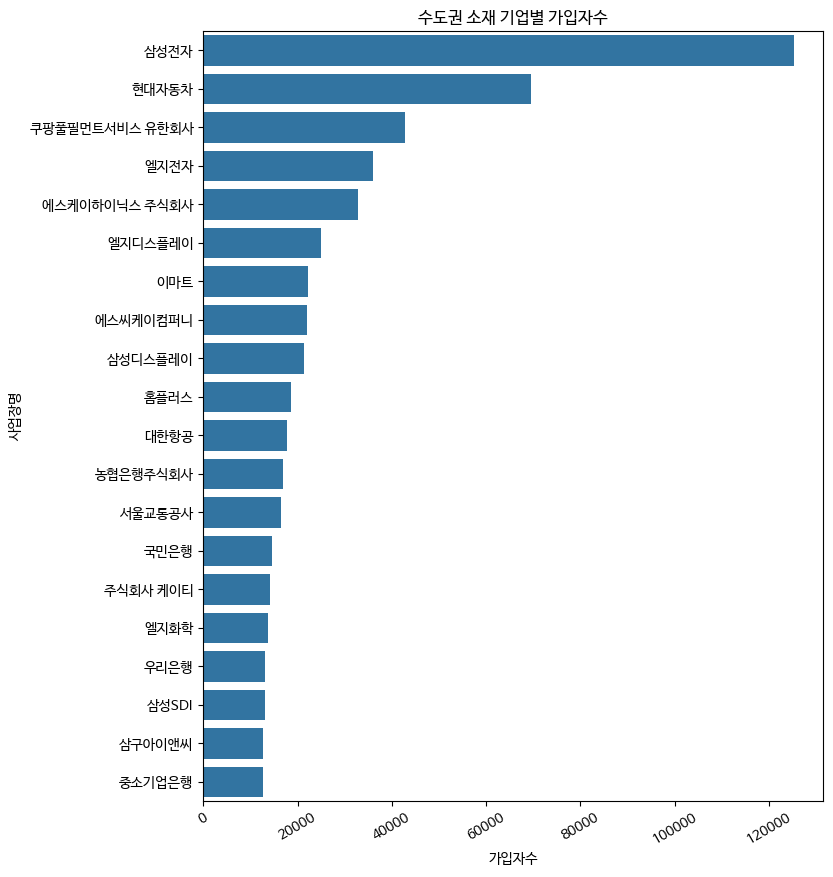

In [41]:
plt.figure(figsize=(8, 10))

tmp = df.loc[df['시도코드'].isin([11, 41]), ['사업장명', '가입자수']].sort_values('가입자수', ascending=False).head(20).reset_index()
sns.barplot(y='사업장명', x='가입자수', data=tmp)

plt.xticks(rotation=30)
plt.title('수도권 소재 기업별 가입자수')
plt.show()

## 국민연금 납부액으로 기업별 평균 연봉 추정

국민연금 보험률은 9%입니다. 쉽게 이야기 하면 급여(신고소득월액)의 9%를 국민연금으로 내는 것입니다.

하지만 이를 절반으로 나누어 **4.5%는 회사가, 나머지 절반은 개인이 부담하는 구조**입니다. 회사는 급여 외에 추가로 금액을 부담합니다.

국민연금 보험료는 **소득 상한선과 하한선이 설정되어 있어 소득 전체가 아닌 일부 소득에만 부과**됩니다.

이를 역산하면 신고소득월액의 계산이 가능합니다. 하지만 **상한선과 하한선이 설정되어 있어 실제보다 과소계산**될 수 있습니다
<br><br>
[수식]

- 인당금액 = 금액 / 가입자수
- 월급여추정 = 인당금액 / 9% * 100%
- 연간급여추정 = 임직원 평균 월급 * 12개월
<br><br>
- 금액을 가입자수로 나눈 금액을 산출하여 `인당금액`을 먼저 산출합니다.
- `월급여추정`은 `인당금액` / 9% * 100% 한 값입니다.
- `월급여추정`을 x12한 값을 `연간급여추정`에 대입합니다.
- `가입자수` 기준 1000명을 초과하는 기업(중견기업)을 필터링 합니다.
- 출력시 `사업장명`, `가입자수`, `월급여추정`, `연간급여추정` 컬럼만 출력합니다.
- `연간급여추정`와 `가입자수`를 기준으로 내림차순하여 상위 10개 기업을 출력합니다.

In [42]:
df.head()

,사업장명,사업자등록번호,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,가입자수,금액,신규,상실
0,우성기전,126811,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,4,809160,0,0
1,희성전자,106810,서울특별시 용산구 독서당로14길,11,170,131,701201,비주거용 건물 임대업(점포 자기땅),315,166182500,1,2
2,디에스디엘,104811,서울특별시 중구 세종대로,11,140,117,701201,비주거용 건물 임대업(점포 자기땅),16,5276400,0,0
3,헤럴드,104810,서울특별시 용산구 후암로4길,11,170,101,221200,잡지 및 정기 간행물 발행업,321,133215600,8,3
4,천일해운,105816,서울특별시 용산구 대사관로12길,11,170,131,519113,상품 종합 도매업,9,2664040,0,0


In [43]:
# 파생변수 추가
# '인당금액', '월급여추청', '연간급여추정'

df['인당금액'] = df['금액'] / df['가입자수']
df['월급여추정'] = df['인당금액'] / 9 * 100
df['연간급여추정'] = df['월급여추정'] * 12

# 확인. 가입자수 1000명 이상
cond = (df['가입자수'] > 1000)

df.sort_values(['연간급여추정', '가입자수'], ascending=False).loc[cond, ['사업장명', '가입자수', '월급여추정', '연간급여추정']].head(10)

,사업장명,가입자수,월급여추정,연간급여추정
6145,기아 영업본부,2089,6170000.0,74040000.0
6425,기아 정비본부,1144,6165498.8,73985986.0
96500,현대제철포항1공장,1388,6160528.3,73926340.1
3249,주식회사 현대케피코,1741,6160289.4,73923472.3
216773,부산항만산업협회 화물고정업,1106,6153108.3,73837299.6
89433,현대제철주식회사,1539,6126279.1,73515349.4
143976,현대위아,2869,6123144.4,73477733.0
191432,삼성디스플레이,21287,6122892.7,73474712.0
43562,현대제철주식회사당진공장,6678,6108163.4,73297961.1
260715,삼성물산건설부문 정규직,4621,6107618.4,73291420.3


## 업종별 가입자수 순유입 산정

- `순유입`은 `신규` - `상실` 로 정의합니다.
- `업종코드명`별 순유입의 합산을 구한 후 상위 20개 `업종코드명`에 대하여 bar 그래프로 출력합니다.
- `순유입` 기준으로 내림차순 정렬합니다.

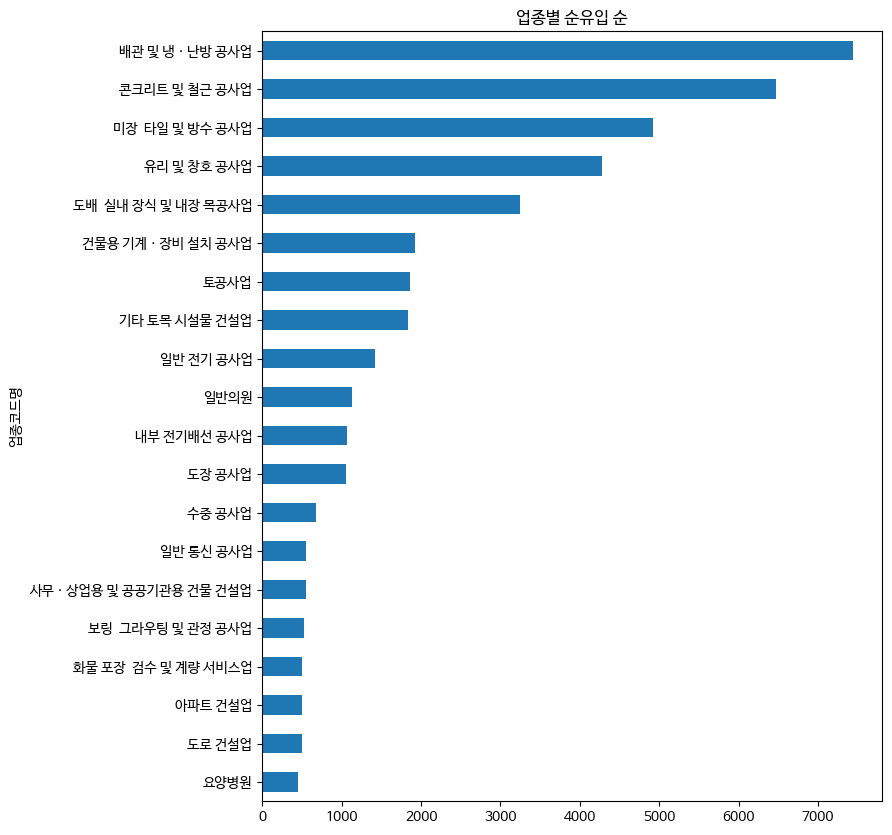

In [45]:
plt.figure(figsize=(8, 10))

df['순유입'] = df['신규'] - df['상실']
df.groupby('업종코드명')['순유입'].sum().sort_values(ascending=False).head(20).sort_values().plot(kind='barh')

plt.title('업종별 순유입 순')
plt.show()

## 사업장명 검색

- 사업장명을 검색한 후 결과를 return하는 함수를 완성합니다.
- 함수명은 `find_company` 입니다.
- 매개변수 contains=:
          True인 경우: string의 `contains`를 사용하여 포함하는 모든 회사를 찾습니다.
          False인 경우: 정확히 일치하는 사업장명만 찾습니다.
          
- `def find_company(company_name, contains)`
- `['사업장명', '월급여추정', '연간급여추정', '업종코드']` 정보를 보여주는 DataFrame을 return 합니다.

In [46]:
df.head()

,사업장명,사업자등록번호,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,가입자수,금액,신규,상실,인당금액,월급여추정,연간급여추정,순유입
0,우성기전,126811,경기도 광주시 도척면 도척윗로,41,610,330,292201,동력식 수지 공구 제조업,4,809160,0,0,202290.0,2247666.7,26972000.0,0
1,희성전자,106810,서울특별시 용산구 독서당로14길,11,170,131,701201,비주거용 건물 임대업(점포 자기땅),315,166182500,1,2,527563.5,5861816.6,70341798.9,-1
2,디에스디엘,104811,서울특별시 중구 세종대로,11,140,117,701201,비주거용 건물 임대업(점포 자기땅),16,5276400,0,0,329775.0,3664166.7,43970000.0,0
3,헤럴드,104810,서울특별시 용산구 후암로4길,11,170,101,221200,잡지 및 정기 간행물 발행업,321,133215600,8,3,415001.9,4611131.9,55333582.6,5
4,천일해운,105816,서울특별시 용산구 대사관로12길,11,170,131,519113,상품 종합 도매업,9,2664040,0,0,296004.4,3288938.3,39467259.3,0


In [47]:
# 코드를 입력해 주세요
def find_company(company_name, contains):
    if contains:
        return df.loc[df['사업장명'].str.contains(company_name), ['사업장명', '월급여추정', '연간급여추정', '업종코드', '가입자수']]\
            .sort_values('가입자수', ascending=False)
    else:
        return df.loc[df['사업장명']==company_name, ['사업장명', '월급여추정', '연간급여추정', '업종코드', '가입자수']]\
            .sort_values('가입자수', ascending=False)

In [48]:
# 검증코드
find_company('에스케이텔레콤', True)

,사업장명,월급여추정,연간급여추정,업종코드,가입자수
3243,에스케이텔레콤,5844013.8,70128165.5,642001,5431
361808,에스케이텔레콤씨에스티원,3979378.4,47752540.5,924101,74
416674,에스케이텔레콤 주 상용 4단계 운항통신시설 구매설치사업,3655629.6,43867555.6,642001,12
535453,에스케이텔레콤 주 상용 오픈 이노베이션 지향 Lv 4 4 자율주행 리빙랩 구축사업,5969688.9,71636266.7,642001,10
448043,에스케이텔레콤 상용 경북 사업장 형태선LTE R,5946222.2,71354666.7,642001,4
238752,에스케이텔레콤 철원동송대리점,3571629.6,42859555.6,515060,3
132824,주식회사 에스케이텔레콤봉화대리점,2444963.0,29339555.6,523323,3


In [49]:
# 검증코드
find_company('에스케이텔레콤', False)

,사업장명,월급여추정,연간급여추정,업종코드,가입자수
3243,에스케이텔레콤,5844013.8,70128165.5,642001,5431


## 업종코드 동일한 회사 비교

- 사업장명을 입력하면 사업장명과 정확히 일치하는 회사를 찾습니다. (find_company 함수 사용)
- 함수명은 `compare_company` 입니다.
- 매개변수명은 `company_name` 으로 지정하세요
- `def compare_company(company_name)`

기능
- find_company로 부터 return 된 DataFrame의 업종코드와 동일한 회사를 모두 찾습니다.
- 동일한 회사의 `월급여추정`, `연간급여추정`에 대한 ['mean', 'count', 'min', 'max']를 산출합니다.

return 되는 DataFrame은 다음과 같이 구성합니다.
- index: `월급여추정` -> `업종_월급여추정`, `연간급여추정` -> `업종_연간급여추정`으로 변경합니다.
- 컬럼은 평균, 개수, 최소, 최대로 컬럼명을 변경 후 맨 끝열에는 찾은 회사명 컬럼을 추가하고, `월급여추정`, `연간급여추정` 데이터를 기입합니다.


In [50]:
def company_info(company_name):
    company = find_company(company_name, True)
    return df.loc[company.iloc[0].name]

In [51]:
# 회사명 입력 -> 회사 정보 출력
info = company_info('에스케이텔레콤')
info

,3243
사업장명,에스케이텔레콤
사업자등록번호,104813
주소,서울특별시 중구 을지로
시도코드,11
시군구코드,140
읍면동코드,105
업종코드,642001
업종코드명,무선 및 위성 통신업
가입자수,5431
금액,2856495500


In [52]:
# 동종 업종 비교
def compare_company(company_name):
    company = find_company(company_name, True)

    code = company['업종코드'].iloc[0]

    df1 = df.loc[df['업종코드'] == code, ['월급여추정', '연간급여추정']].agg(['mean', 'count', 'min', 'max'])
    df1.columns = ['업종_월급여추정', '업종_연간급여추정']
    df1 = df1.T
    df1.columns = ['평균', '개수', '최소', '최대']
    df1.loc['업종_월급여추정', company_name] = company['월급여추정'].values[0]
    df1.loc['업종_연간급여추정', company_name] = company['연간급여추정'].values[0]

    return df1

In [53]:
# 검증코드
result = compare_company('삼성전자')
result

,평균,개수,최소,최대,삼성전자
업종_월급여추정,3358482.5,435.0,568972.7,6122892.7,5907269.9
업종_연간급여추정,40301789.9,435.0,6827673.0,73474712.0,70887238.8


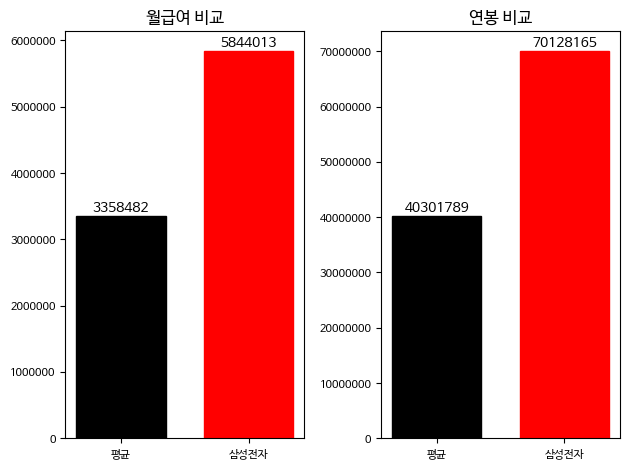

In [55]:
fig, ax = plt.subplots(1, 2)

p1 = ax[0].bar(x=['평균', '삼성전자'], height=(result.iloc[0, 0], info['월급여추정']), width=0.7)
ax[0].bar_label(p1, fmt='%d')
p1[0].set_color('black')
p1[1].set_color('red')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('월급여 비교')

p2 = ax[1].bar(x=['평균', '삼성전자'], height=(result.iloc[1, 0], info['연간급여추정']), width=0.7)
p2[0].set_color('black')
p2[1].set_color('red')
ax[1].bar_label(p2, fmt='%d')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title('연봉 비교')

ax[0].tick_params(axis='both', which='major', labelsize=8, rotation=0)
ax[0].tick_params(axis='both', which='minor', labelsize=6)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].tick_params(axis='both', which='minor', labelsize=6)

plt.tight_layout() # 플롯의 레이아웃을 자동으로 조정해, 서브플롯이나 레이블, 타이틀 등이 겹치지 않도록 여백을 최적화

In [ ]:
# 검증코드
compare_company('현대자동차')

In [ ]:
# 검증코드
compare_company('버킷플레이스')

In [ ]:
# 검증코드
compare_company('무신사')